In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

import scipy.stats as sps
from time import perf_counter, sleep
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [10,7]

import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend='plotly'
print("setup complete !")

setup complete !


On considère un processus stochastique en dimension 1 :
$$dX(t)=-V'(X(t)) dt + \sqrt{2 \varepsilon}\ dB(t)$$
où $V:\mathbb R \to \mathbb R$ est une fonction potentielle, $\varepsilon >0$ fixe l'intensité du bruit et $(B(t))_{t \ge 0}$ est un mouvement brownien standard. Pour deux réels $a<b$, on note $\tau_a= \inf\{t \ge 0, X(t)<a\}$ et  $\tau_b= \inf\{t \ge 0, X(t)>b\}$. Pour une condition initiale $X(0)=x_0 \in (a,b)$ fixée, on souhaite évaluer
$$p=\mathbb P(\tau_b < \tau_a)$$
dans le cas où cette probabilité est très petite.

On introduit un pas de temps $\delta_t>0$ et la discrétisation suivante : pour tout $k \ge 0$,
$$X_{k+1} = X_k - V'(X_k) \delta_t + \sqrt{2 \varepsilon \delta_t}\ G_k$$
où $(G_k)_{k \ge 0}$ est une suite i.i.d. de gaussiennes centrées réduites. On considère donc des trajectoires $(X_k)_{0 \le k \le T_a \wedge T_b}$ où $T_a=\min\{k\ge 0, \, X_k < a\}$ et $T_b=\min\{k\ge 0, \, X_k > b\}$.

#### Question 2.0 #### 
Représenter la fonction potentielle $V(x)=\frac{x^4}{4}-\frac{x^2}{2}+\frac{x^3}{3}$ sur l'intervalle $[-1.5;1.5]$.

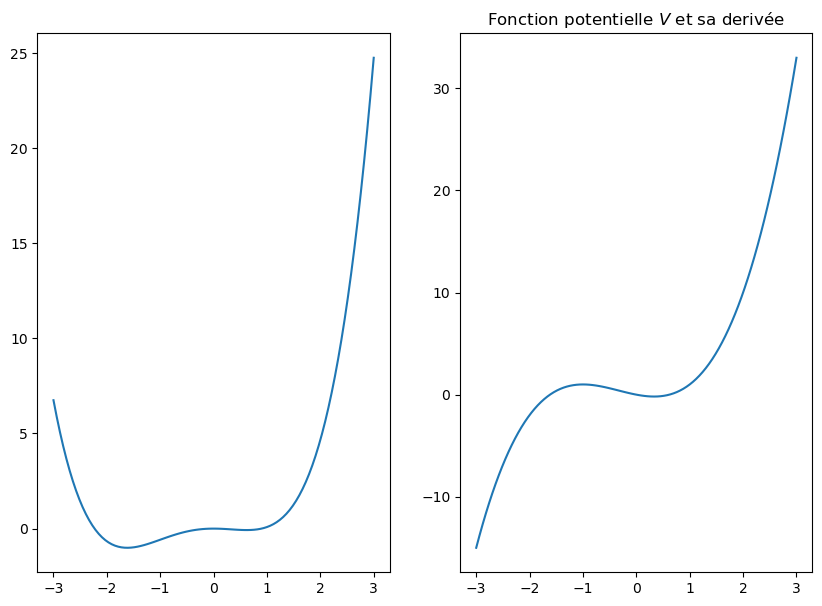

In [2]:
V= lambda x : x**4/4-x**2/2+x**3/3
Vprime= lambda x :x**3-x+x**2
     

x = np.linspace(-3, 3, num=100)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, V(x))
ax2.plot(x, Vprime(x))
plt.title("Fonction potentielle $V$ et sa derivée ");

In [3]:
from scipy.optimize import minimize_scalar

def V(x):
    return (x**4)/4 - (x**2)/2 + (x**3)/3

extremas = [(res_min.x, V(res_min.x)) for i in range(1,3) for res_min in [minimize_scalar(V, bounds=(-3+i, -3+i+1), method='bounded')]]
(x1,_),(x2,_)=extremas

In [4]:
x1,x2

(-1.618033988749895, -0.9999940391390134)

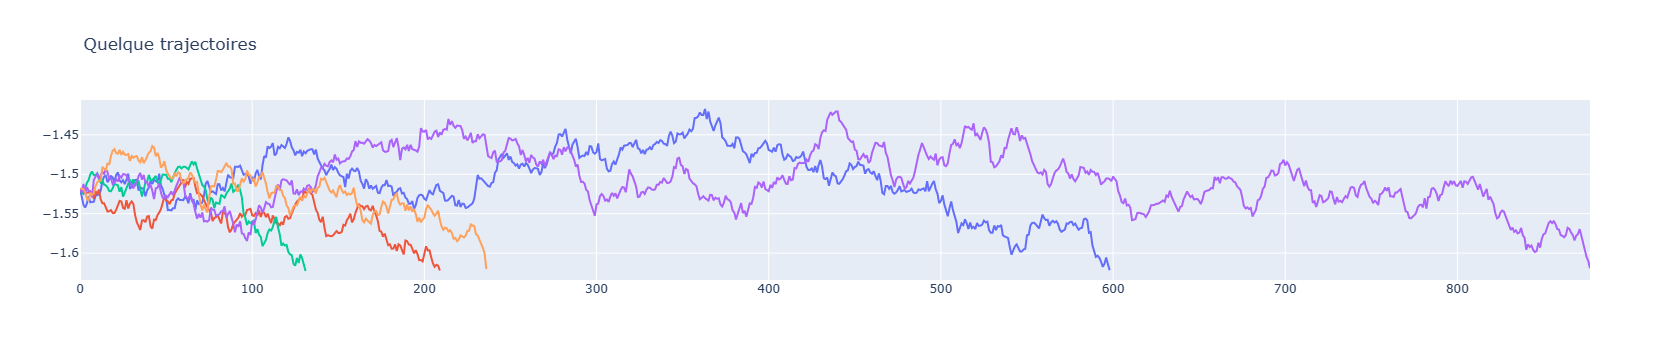

In [5]:
a = x1
b = x2
x0 = x1+0.1
epsilon = 0.02
dt = 0.001
sigma = np.sqrt(2*epsilon*dt)

# Simulation d'une trajectoire



def sim_traj(a, b, x0, epsilon, dt):
    X = [x0]
    sigma = np.sqrt(2 * epsilon * dt)
    while X[-1] >= a and X[-1] <= b:
        X.append(X[-1] - Vprime(X[-1]) * dt + sigma * sps.norm.rvs())
    X = np.asarray(X)
    return X

tt=[sim_traj(a, b, x0, epsilon, dt) for _ in range(5)]
traj1 = go.Scatter(x=list(range(len(tt[0]))), y=tt[0])
traj2 = go.Scatter(x=list(range(len(tt[1]))), y=tt[1])
traj3 = go.Scatter(x=list(range(len(tt[2]))), y=tt[2])
traj4 = go.Scatter(x=list(range(len(tt[3]))), y=tt[3])
traj5 = go.Scatter(x=list(range(len(tt[4]))), y=tt[4])

# Add the traces to a data list
data = [traj1, traj2, traj3, traj4, traj5]

# Define the layout
layout = go.Layout(title='Quelque trajectoires')

# Create the figure
fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=False)

# Show the figure
fig.show()


**SIMULATION MONTE CARLO**



**CETTE CELLULE PREND ENVIRON 30min POUR S'EXECUTER. NOUS AVONS SAUVEGARDER LES RESULTATS DANS UN FICHIER CSV QUE NOUS AVON MIS EN LIGNE POUR FACILITER LA VISUALISATION DES DONNEES**

alpha = 0.05
n = 100000
epsilons=[1,0.75,0.5,0.2,0.1,0.05,0.02,0.01]
values=[]
for epsilon in epsilons:
    print(f"debut epsilon = {epsilon}")
    trajs=[] 
    sigma = np.sqrt(2*epsilon*dt)


    compteur=0
    for i in tqdm(range(n)):
        temp=[x0]
        X = x0
        while a <= X <= b:
            X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
            temp.append(X)
        if X>b:
            compteur += 1
            trajs.append(temp)
            temp=[x0]
            
    phat = compteur/n
    rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
    borneinf = phat-rayon
    bornesup = phat+rayon

    values.append([epsilon,phat,[borneinf,bornesup],trajs])
    print(f"fin epsilon ={epsilon}")

    
df = pd.DataFrame(values)
df = df.reset_index(drop=True)
df = df.rename(columns={0:"epsilon", 1:"proba" ,2:"CI",3:"trajs"})
df.to_csv('results MC.csv', index=False)
df



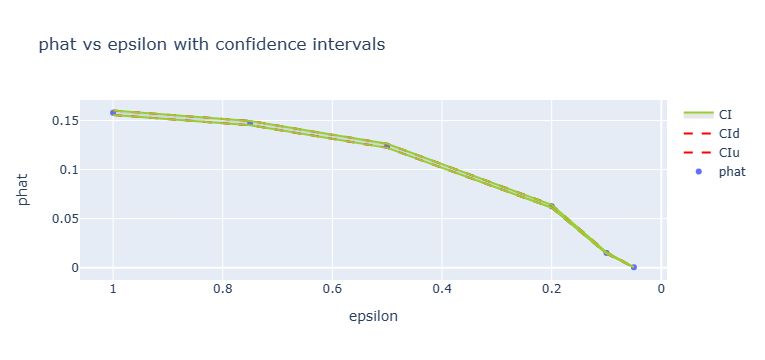

In [12]:
from ast import literal_eval

df=pd.read_csv('https://dl.dropboxusercontent.com/s/hw2qdb32kgb34tw/results%20MC.csv', converters={'1': literal_eval}, on_bad_lines='skip')
import ast
ciu,cid=[],[]
for i in range(6):
    ciu.append(ast.literal_eval(df.loc[i].CI)[1])
    
    cid.append(ast.literal_eval(df.loc[i].CI)[0])
    
df['cid']=cid
df['ciu']=ciu
scatter_trace = go.Scatter(
    x=df['epsilon'],
    y=df['proba'],
    mode='markers',
    name='phat'
)

ciu_trace = go.Scatter(
    x=df['epsilon'],
    y=df['ciu'],
    mode='lines',
    name='CIu',
    line=dict(color='red', dash='dash')
)

cid_trace = go.Scatter(
    x=df['epsilon'],
    y=df['cid'],
    mode='lines',
    name='CId',
    line=dict(color='red', dash='dash')
)

fill_trace = go.Scatter(
    x=df['epsilon'],
    y=df['ciu'],
    mode='lines',
    line=dict(color='yellowgreen'),
    showlegend=False
)

fill_trace2 = go.Scatter(
    x=df['epsilon'],
    y=df['cid'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(128,128,128,0.2)',
    line=dict(color='yellowgreen'),
    name='CI'
)

layout = go.Layout(
    title='phat vs epsilon with confidence intervals',
    xaxis=dict(title='epsilon'),
    yaxis=dict(title='phat')
)

fig = go.Figure(data=[scatter_trace, ciu_trace, cid_trace, fill_trace, fill_trace2], layout=layout)
fig.update_layout(
    xaxis = dict(autorange="reversed")
)
fig.show()

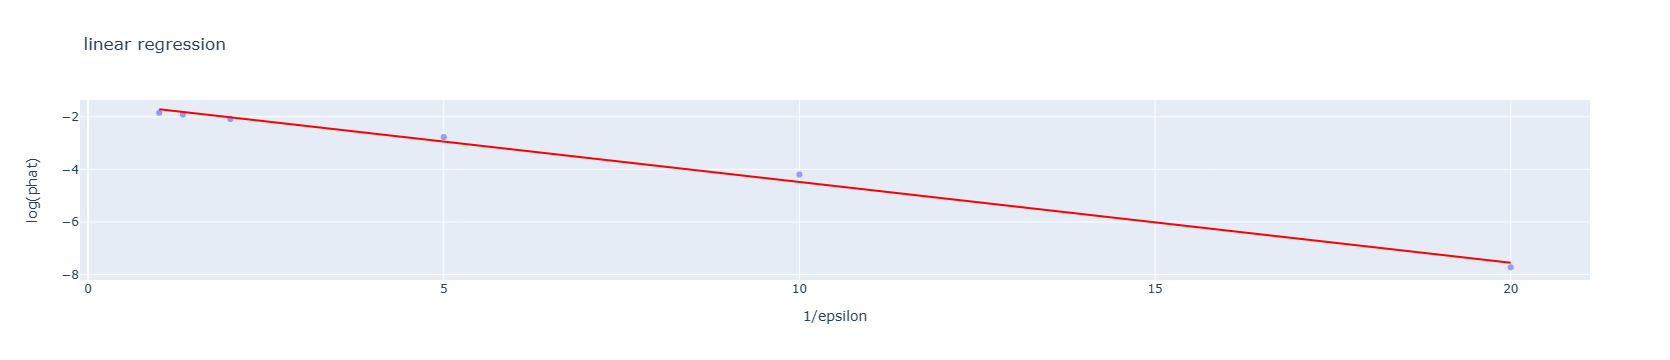

In [7]:
y=np.log(df['proba'])
x=1/df['epsilon']
fig = px.scatter(
    x=x, y=y, opacity=0.65,
    trendline='ols', trendline_color_override='red',
    title="linear regression",
    labels= {'x':"1/epsilon",'y':'log(phat)'}
    
    
)
fig.show()

**EPSILON = 1**

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:30<00:00, 175.26it/s]


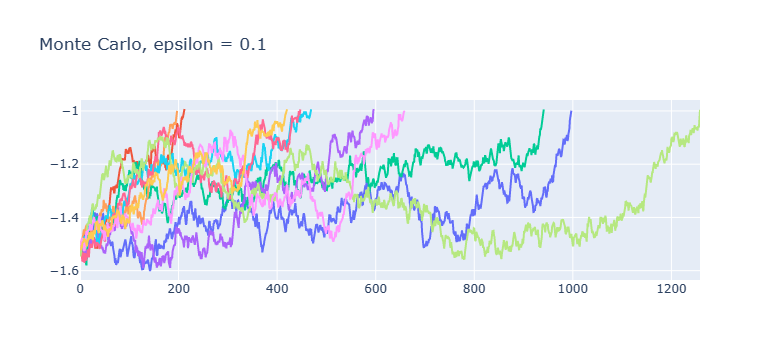

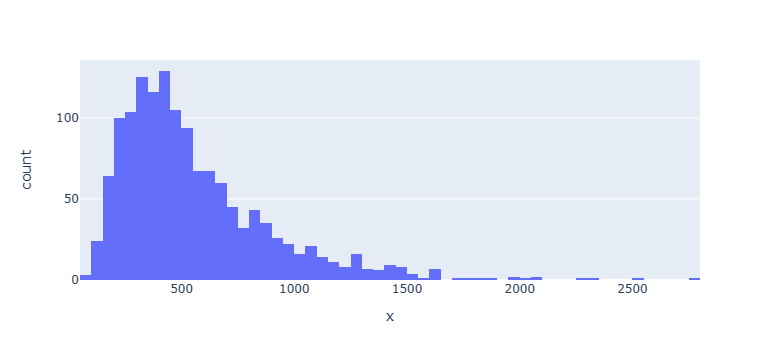

In [13]:
epsilon = 0.1
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = int(1e5)

t0 = perf_counter()
compteur = 0
lengths =[]
trajs=[]
for i in tqdm(range(n)):
    temp=[x0]
    X = x0
    while a <= X <= b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
        temp.append(X)
    if X>b:
        compteur += 1
        lengths.append(len(temp))
        trajs.append(temp)
        temp=[x0]
        
phat = compteur/n
rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
borneinf = phat-rayon
bornesup = phat+rayon


    
# Affichage
data=[go.Scatter(x=list(range(len(trajs[_]))), y=trajs[_]) for _ in range(10)]
# Define the layout
layout = go.Layout(title=f'Monte Carlo, epsilon = {epsilon}')

# Create the figure
fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=False)

# Show the figure
fig.show()




fig = px.histogram( x=lengths)
fig.show()


In [138]:
np.log(epsilon)-c

-5.998990499544224

In [101]:
np.savetxt("hh.txt",lengths,fmt = '%i')

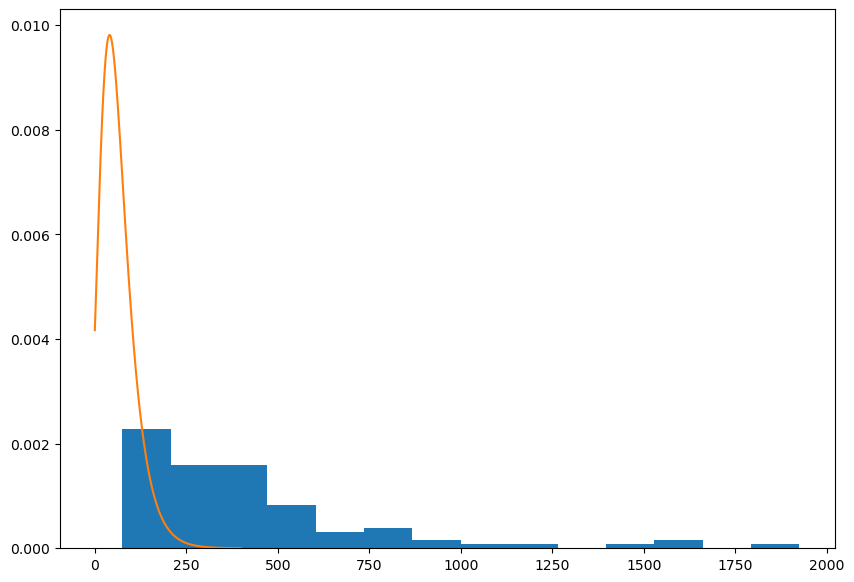

In [139]:
plt.hist(lengths,bins='auto', density='true',label="histogramme")

c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)


t = np.linspace(0,400, num=3000)

plt.plot(t,sps.gumbel_r.pdf(t, loc = 40.3311808852516, scale = 37.5020493041378), label=r"$-\log\varepsilon+G+c$")

plt.show()

In [73]:
df.lengths


0    [145, 36, 60, 119, 170, 31, 24, 36, 74, 73, 78...
1    [121, 370, 51, 44, 116, 69, 72, 81, 135, 104, ...
2    [90, 247, 95, 101, 144, 63, 133, 244, 307, 89,...
3    [291, 93, 331, 205, 220, 455, 347, 320, 160, 4...
4    [814, 858, 205, 546, 423, 817, 197, 580, 263, ...
5    [656, 1081, 1088, 322, 804, 811, 1109, 673, 53...
Name: lengths, dtype: object

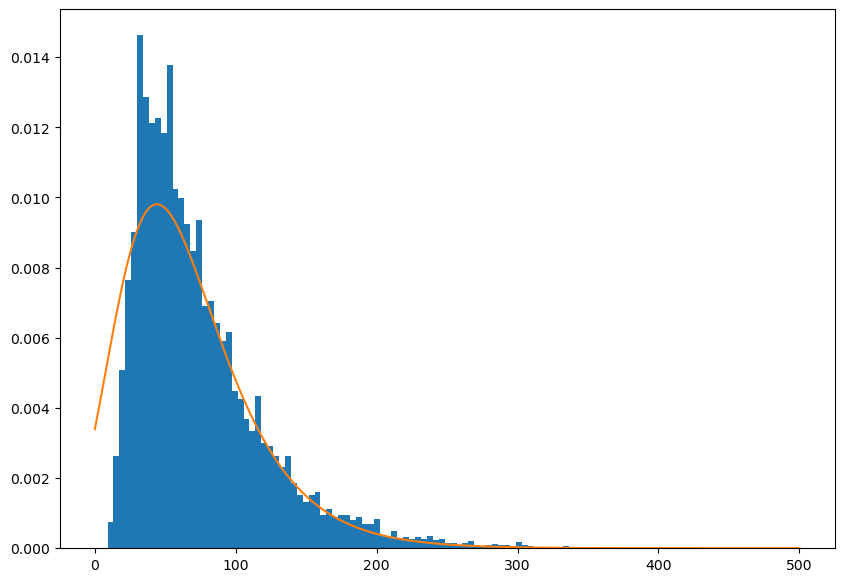

In [14]:
x=df.lengths
np.savetxt("x.txt",ast.literal_eval(x[0]),fmt = '%i')
len(ast.literal_eval(x[0]))
plt.hist(ast.literal_eval(x[0]),bins='auto', density='true',label="histogramme")


duree = np.zeros(n)
c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)
c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)


t = np.linspace(0,500, num=3000)

plt.plot(t,sps.gumbel_r.pdf(t+np.log(epsilon)-c,loc = 40.3311808852516, scale = 37.5020493041378), label=r"$-\log\varepsilon+G+c$")



plt.show()

**SIMULATION adaptive multilevel splitting**

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 92.42it/s]


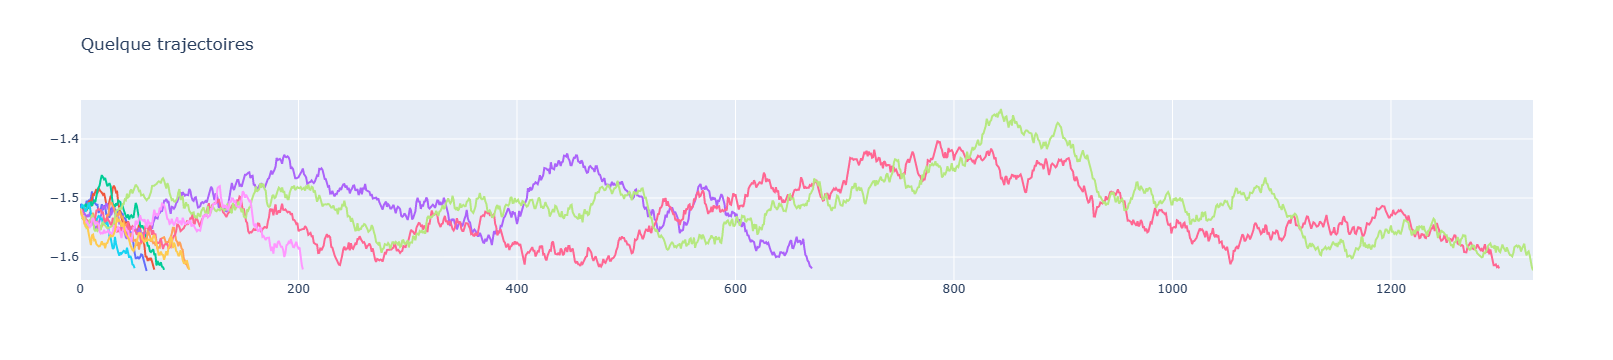

In [114]:
epsilon = 0.02
n = 10
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
p = 1

for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.array(X)
    X_AMS.append(X)

# Calcul des maxima
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
p *= (1-K.size/n)
    
# Affichage
data=[go.Scatter(x=list(range(len(X_AMS[i]))), y=X_AMS[i]) for i in range(n)]
# Define the layout
layout = go.Layout(title='Quelque trajectoires')

# Create the figure
fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=False)

# Show the figure
fig.show()

**on applique dans les celulle suivant AMS aux 8 valeurs de epsilon prises pour MC naif**

In [120]:
ams_results= pd.DataFrame(columns=['epsilon','phat','CIu','CId'],index=range(8))


In [121]:


epsilon = 1
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[0]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 780.88it/s]


Durée (s) : 0.4
L'estimation de la probabilité pour epsilon = 1 est 2.16e-01
Intervalle de confiance asymptotique : [1.63e-01,2.68e-01]


In [122]:


epsilon = 0.75
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[1]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 804.34it/s]

Durée (s) : 0.5
L'estimation de la probabilité pour epsilon = 0.75 est 1.47e-01
Intervalle de confiance asymptotique : [1.07e-01,1.86e-01]


In [123]:


epsilon = 0.5
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[2]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 560.12it/s]


Durée (s) : 0.7
L'estimation de la probabilité pour epsilon = 0.5 est 1.46e-01
Intervalle de confiance asymptotique : [1.07e-01,1.86e-01]


In [124]:


epsilon = 0.2
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[3]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.97it/s]


Durée (s) : 2.1
L'estimation de la probabilité pour epsilon = 0.2 est 6.49e-02
Intervalle de confiance asymptotique : [4.38e-02,8.59e-02]


In [125]:


epsilon = 0.1
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[4]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 181.74it/s]


Durée (s) : 4.6
L'estimation de la probabilité pour epsilon = 0.1 est 1.35e-02
Intervalle de confiance asymptotique : [8.04e-03,1.90e-02]


In [126]:


epsilon = 0.05
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[5]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.98it/s]


Durée (s) : 10.8
L'estimation de la probabilité pour epsilon = 0.05 est 3.74e-04
Intervalle de confiance asymptotique : [1.68e-04,5.80e-04]


In [127]:


epsilon = 0.02
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[6]=[epsilon,phat,bornesup,borneinf]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 115.95it/s]


Durée (s) : 35.2
L'estimation de la probabilité pour epsilon = 0.02 est 1.81e-09
Intervalle de confiance asymptotique : [2.18e-10,3.40e-09]


In [128]:


epsilon = 0.01
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])
    lengths.append(len(X_AMS[i]))

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    # print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()

    phat *= (1-K.size/n)

sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité pour epsilon = {epsilon } est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

ams_results.loc[7]=[epsilon,phat,bornesup,borneinf]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.97it/s]


Durée (s) : 77.6
L'estimation de la probabilité pour epsilon = 0.01 est 4.24e-18
Intervalle de confiance asymptotique : [-1.02e-18,9.49e-18]


In [9]:
pd.options.display.float_format = '{:.20f}'.format

ams_results

NameError: name 'ams_results' is not defined

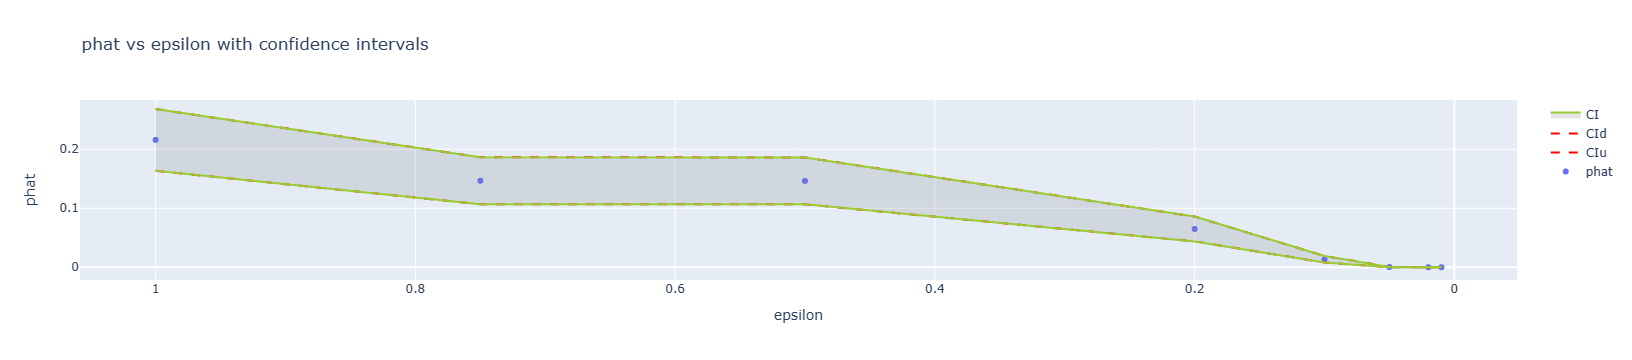

In [130]:
scatter_trace = go.Scatter(
    x=ams_results['epsilon'],
    y=ams_results['phat'],
    mode='markers',
    name='phat'
)

ciu_trace = go.Scatter(
    x=ams_results['epsilon'],
    y=ams_results['CIu'],
    mode='lines',
    name='CIu',
    line=dict(color='red', dash='dash')
)

cid_trace = go.Scatter(
    x=ams_results['epsilon'],
    y=ams_results['CId'],
    mode='lines',
    name='CId',
    line=dict(color='red', dash='dash')
)

fill_trace = go.Scatter(
    x=ams_results['epsilon'],
    y=ams_results['CIu'],
    mode='lines',
    line=dict(color='yellowgreen'),
    showlegend=False
)

fill_trace2 = go.Scatter(
    x=ams_results['epsilon'],
    y=ams_results['CId'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(128,128,128,0.2)',
    line=dict(color='yellowgreen'),
    name='CI'
)

layout = go.Layout(
    title='phat vs epsilon with confidence intervals',
    xaxis=dict(title='epsilon'),
    yaxis=dict(title='phat')
)

fig = go.Figure(data=[scatter_trace, ciu_trace, cid_trace, fill_trace, fill_trace2], layout=layout)
fig.update_layout(
    xaxis = dict(autorange="reversed")
)
fig.show()

In [136]:
np.log(ams_results.phat.astype(float))


0    -1.53307458256068773750
1    -1.91977221557266308771
2    -1.92153177508156103315
3    -2.73540490799414603984
4    -4.30191770406223383816
5    -7.89137154500281301495
6   -20.12977695763554564223
7   -40.00275935939964710997
Name: phat, dtype: float64

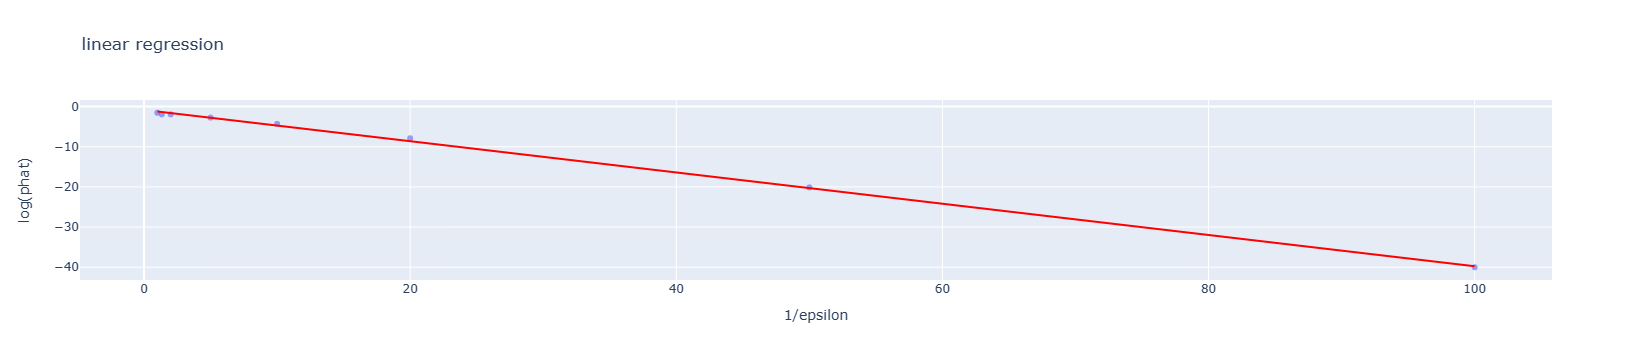

In [137]:
y=np.log(ams_results['phat'].astype(float))
x=1/ams_results['epsilon']
fig = px.scatter(
    x=x, y=y, opacity=0.65,
    trendline='ols', trendline_color_override='red',
    title="linear regression",
    labels= {'x':"1/epsilon",'y':'log(phat)'}
    
    
)
fig.show()

**TEMPS DE TRANSITION**

On s'intéresse désormais au temps moyen $T_{12}$ d'une transition de $x_1$ à $x_2$. Plus précisément, on considère une longue trajectoire $\left(X_t\right)_{t \geq 0}$ de (1) et on s'intéresse à
$$
T_{12}=\lim _{K \rightarrow \infty} \frac{1}{K} \sum_{k=1}^K\left(\tau_2^k-\tau_1^k\right)
$$
où, pour $k \geq 1$,
$$
\tau_1^k=\inf \left\{t>\tau_2^{k-1}, X_t<x_1\right\} \text { et } \tau_2^k=\inf \left\{n>\tau_1^k, X_t>x_2\right\}
$$
sont les temps de visite successifs de $x_1$ et $x_2$ (avec la convention $\tau_2^0=-\infty$ ).


3. Estimer par une méthode de Monte Carlo naïve le temps $T_{12}$, en commençant par des valeurs de $\epsilon$ assez grandes. Tracer des trajectoires de transitions $\left(X_n\right)_{\tau_1^k \leq n \leq \tau_2^k}$. Que se passe-t-il quand $\epsilon$ tend vers 0 ?

In [10]:

epsilon = 1
K = 1000

# Estimer T_12
x0 = x1+0.1

def T12(epsilon,K=1000):
    sigma = np.sqrt(2*epsilon*dt)

    T1,T2=[],[]
    X=[x0]
    t0,t1,t2=0,0,0
    for k in range(K):
        while True:
            t1 = t0 + dt
            X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
            if X[-1] < x1:
                    tau1 = t1
                    break
            t0 = t1
        while True:
            t2 = t1 + dt
            X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
            if X[-1] > x2:
                tau2 = t2
                break
        T1.append(tau1)
        T2.append(tau2)
    return 1/len(T1)*sum([T2[i]-T1[i] for i in range(len(T1))]),X

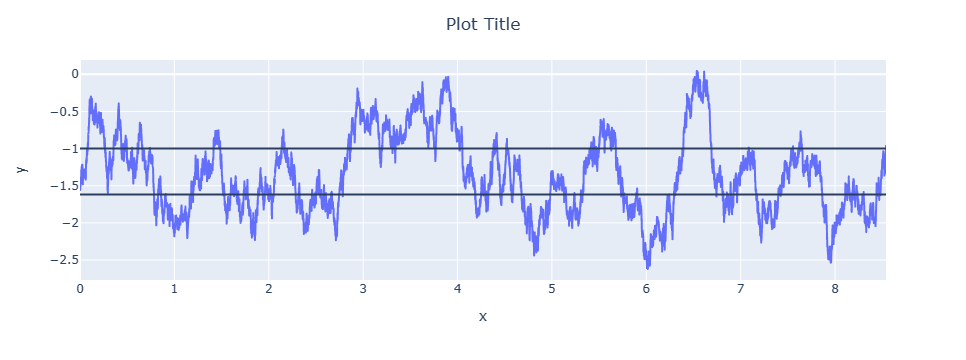

In [11]:
proba ,traj = T12(epsilon,K=10)
fig=px.line(x=np.arange(len(traj))*dt,y=traj)


fig.add_hline(y=x1)
fig.add_hline(y=x2)
fig.update_layout(
    title={
        'text': "Plot Title",
       'y':0.95,
        'x':0.5,
        
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [84]:
nb_mc=100
epsilons=[1,0.75,0.5,0.2,0.1]

T=[]
for epsilon in epsilons:
    print(f"starting MC for epsilon = {epsilon}")
    t=0
    for _ in tqdm(range(nb_mc)):
        t+=T12(epsilon,K=100)[0]
    print (t/nb_mc)
    T.append(t)


starting MC for epsilon = 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.41s/it]


0.0010000000000008056
starting MC for epsilon = 0.75


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:41<00:00,  4.01s/it]


0.0010000000000010018
starting MC for epsilon = 0.5


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:10<00:00,  4.90s/it]


0.0010000000000012646
starting MC for epsilon = 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:23<00:00, 12.24s/it]


0.001000000000000587
starting MC for epsilon = 0.1


100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [1:57:14<00:00, 70.34s/it]

0.00100000000000035


In [24]:
T

[0.0010000000000008056,
 0.0010000000000010018,
 0.0010000000000012646,
 0.001000000000000587,
 0.00100000000000035]

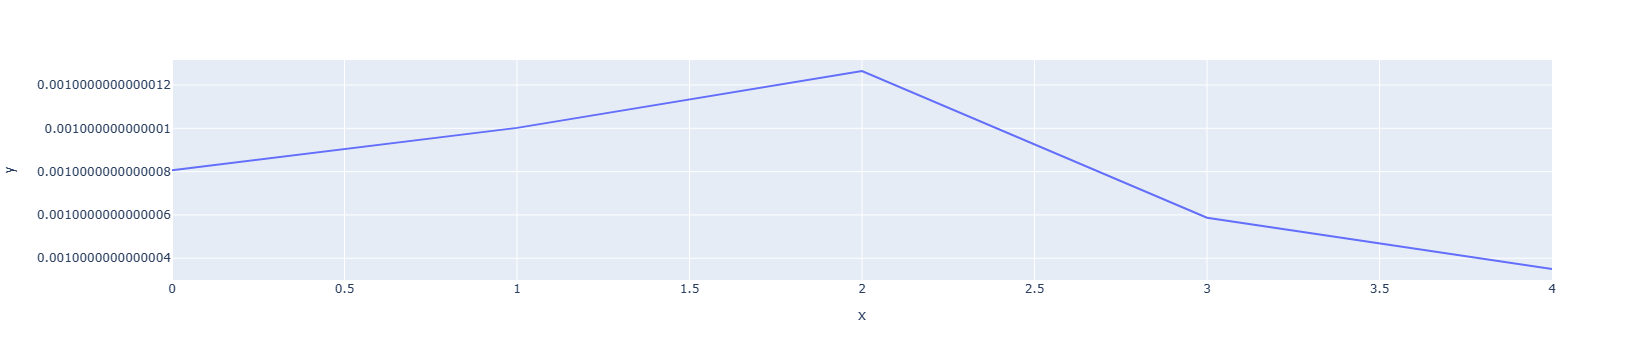

In [25]:
fig=px.line(y=T)
fig.show()